In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import cv2
import os
import PIL
import pathlib
import splitfolders

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

In [13]:
base_ds = "C:/Users/SamChan/Documents/FYP/FYP/FYP Project/data"
base_ds = pathlib.Path(base_ds)

In [14]:
splitfolders.ratio(base_ds, output='imgs', seed=123, ratio=(.7,.15,.15), group_prefix=None)

Copying files: 2000 files [00:04, 487.47 files/s]


In [15]:
aqil = [fn for fn in os.listdir(f'{base_ds}/aqil') if fn.endswith('.jpg')]
daim = [fn for fn in os.listdir(f'{base_ds}/daim') if fn.endswith('.jpg')]
danish = [fn for fn in os.listdir(f'{base_ds}/danish') if fn.endswith('.jpg')]
nawal = [fn for fn in os.listdir(f'{base_ds}/nawal') if fn.endswith('.jpg')]
names = [aqil, daim, danish, nawal]
name_classes = []
for i in os.listdir('imgs/train'):
    name_classes+=[i]
name_classes.sort()

Total images: 2000
Total number of classes: 4
Total aqil images: 500
Total daim images: 500
Total danish images: 500
Total nawal images: 500


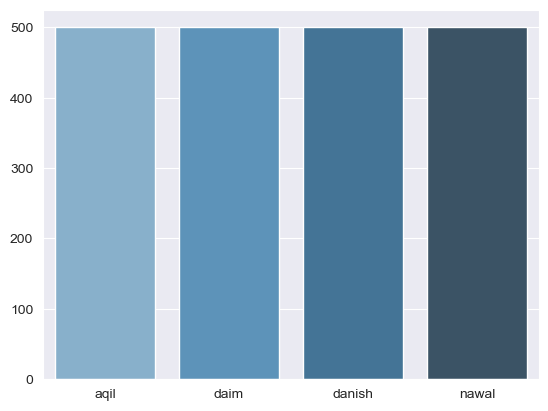

In [16]:
image_count = len(list(base_ds.glob('*/*.jpg')))
print(f'Total images: {image_count}')
print(f'Total number of classes: {len(name_classes)}')
count = 0
name_count = []
for x in name_classes:
  print(f'Total {x} images: {len(names[count])}')
  name_count.append(len(names[count]))
  count += 1

sns.set_style('darkgrid')
sns.barplot(x=name_classes, y=name_count, palette="Blues_d")
plt.show()

Image dimensions: (244, 244, 3)


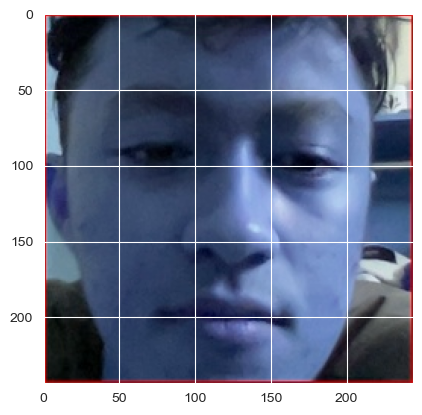

In [17]:
sample_img = cv2.imread("C:/Users/SamChan/Documents/FYP/FYP/FYP Project/data/aqil/12.jpg")
plt.imshow(sample_img)
print(f'Image dimensions: {sample_img.shape}')

In [18]:
def load_random_img(dir, label):
  plt.figure(figsize=(10,10))
  i=0
  for label in name_classes:
    i+=1
    plt.subplot(1, 5, i)
    file = random.choice(os.listdir(f'{dir}/{label}'))
    image_path = os.path.join(f'{dir}/{label}', file)
    img=cv2.imread(image_path)
    plt.title(label)
    plt.imshow(img)
    plt.grid(None)
    plt.axis('off')

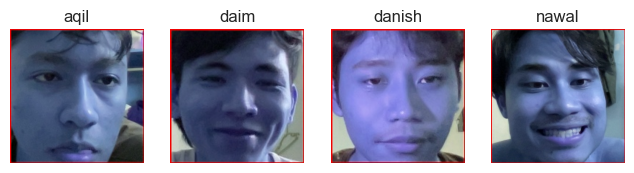

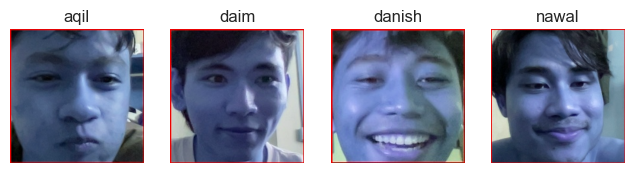

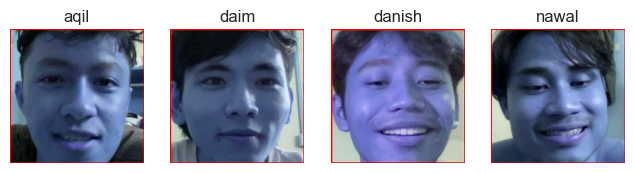

In [19]:
for i in range(3):
  load_random_img(base_ds, name_classes)

In [20]:
batch_size = 32
img_height, img_width = 180, 180
input_shape = (img_height, img_width, 3)

In [21]:
datagen = ImageDataGenerator(rescale=1./255)

In [22]:
train_ds = datagen.flow_from_directory(
    'imgs/train',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    subset = "training",
    class_mode='categorical')

val_ds = datagen.flow_from_directory(
    'imgs/val',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

test_ds = datagen.flow_from_directory(
    'imgs/test',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

Found 1400 images belonging to 4 classes.
Found 300 images belonging to 4 classes.
Found 300 images belonging to 4 classes.


In [23]:
def plot_train_history(history):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [24]:
model_vanilla = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16,(7,7), activation='relu', input_shape=input_shape),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(16,(7,7),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(axis = 3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(32,(3,3), activation='relu', input_shape=input_shape),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(axis = 3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(axis = 3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(axis = 3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(4, activation='softmax')
])

In [25]:
model_vanilla.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_vanilla.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 174, 174, 16)      2368      
                                                                 
 batch_normalization (BatchN  (None, 174, 174, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 174, 174, 16)      12560     
                                                                 
 batch_normalization_1 (Batc  (None, 174, 174, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 87, 87, 16)       0         
 )                                                               
                                                        

In [78]:
models_dir = "C:/Users/SamChan/Documents/FYP/FYP/FYP Project/my_model/"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

checkpointer = ModelCheckpoint(filepath='C:/Users/SamChan/Documents/FYP/FYP/FYP Project/my_model/my_model_VanillaCNN.h5', 
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=3, min_lr=0.001)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [80]:
history1 = model_vanilla.fit(train_ds, epochs = 15, validation_data = val_ds, callbacks=callbacks)

Epoch 1/15
88/88 [==============================] - ETA: 0s - loss: 0.0293 - accuracy: 0.9936
Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to C:/Users/SamChan/Documents/FYP/FYP/FYP Project/my_model\model_vanilla.hdf5
88/88 [==============================] - 157s 2s/step - loss: 0.0293 - accuracy: 0.9936 - val_loss: 2.0214 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 2/15
88/88 [==============================] - ETA: 0s - loss: 0.0084 - accuracy: 0.9989
Epoch 2: val_accuracy improved from 0.25000 to 0.51333, saving model to C:/Users/SamChan/Documents/FYP/FYP/FYP Project/my_model\model_vanilla.hdf5
88/88 [==============================] - 155s 2s/step - loss: 0.0084 - accuracy: 0.9989 - val_loss: 1.0218 - val_accuracy: 0.5133 - lr: 0.0010
Epoch 3/15
88/88 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 0.9996
Epoch 3: val_accuracy improved from 0.51333 to 0.74167, saving model to C:/Users/SamChan/Documents/FYP/FYP/FYP Project/my_model\model_vanilla

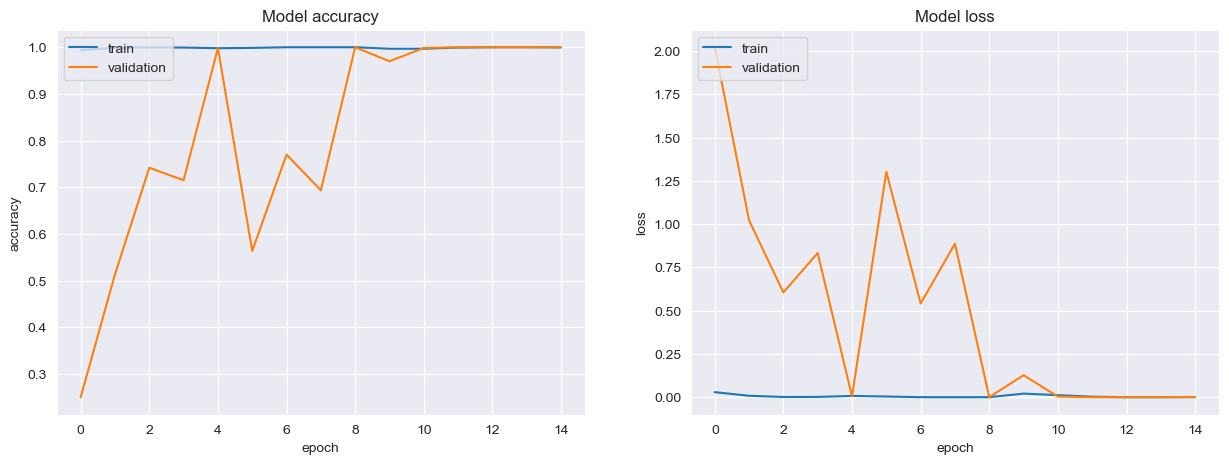

In [81]:
model_vanilla.load_weights('C:/Users/SamChan/Documents/FYP/FYP/FYP Project/my_model/model_vanilla.hdf5')
plot_train_history(history1)

In [82]:
score1 = model_vanilla.evaluate(test_ds, verbose=1)

19/19 [==============================] - 5s 286ms/step - loss: 2.7119e-04 - accuracy: 1.0000


In [83]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model_vanilla.predict(test_ds)

19/19 [==============================] - 5s 225ms/step


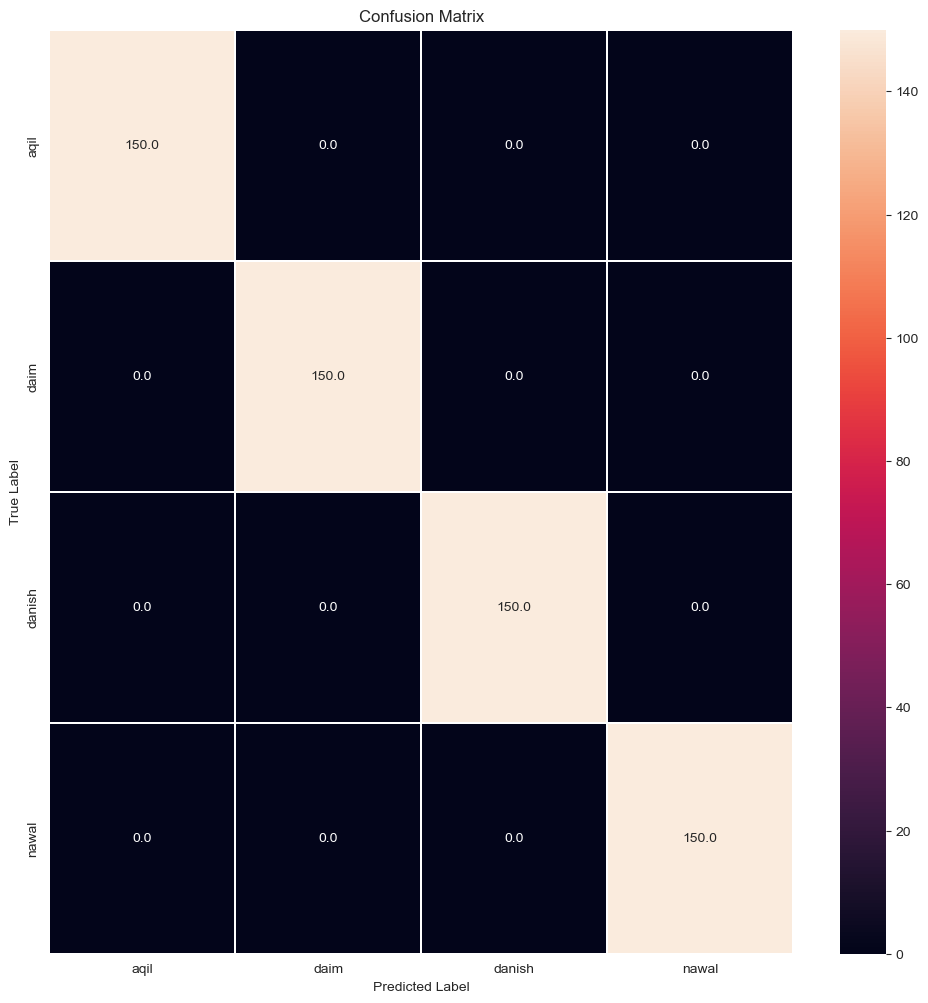

In [84]:
y_pred = np.argmax(Y_pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, test_ds.classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_ds.class_indices)
ax.yaxis.set_ticklabels(name_classes)
plt.title("Confusion Matrix")
plt.show()

In [87]:
diag = np.diag(confusion_mtx)

sum_diag = np.sum(diag)

total_instance = np.sum(confusion_mtx)
gar = sum_diag/total_instance
print("Genuine Acceptance Rate :", gar)

Genuine Acceptance Rate : 1.0


In [85]:
report1 = classification_report(test_ds.classes, y_pred, target_names=name_classes, output_dict=True)
df1 = pd.DataFrame(report1).transpose()
df1

,precision,recall,f1-score,support
aqil,1.0,1.0,1.0,150.0
daim,1.0,1.0,1.0,150.0
danish,1.0,1.0,1.0,150.0
nawal,1.0,1.0,1.0,150.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,600.0
weighted avg,1.0,1.0,1.0,600.0
